# 기본 함수 및 라이브러리 로드

In [1]:
# 경고 제어
import warnings
warnings.filterwarnings('ignore')

# 기본 전처리
import numpy as np
import geopandas as gpd
import pandas as pd
pd.set_option('display.max_columns', 150)
pd.set_option('display.width', 10000)
pd.options.display.float_format = '{:.4f}'.format

# 시각화
import folium
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.rcParams['figure.figsize'] = (12, 9)
from scipy.stats import norm

## 필요 함수 로드

In [2]:
def get_object_type(df):
    """ 
    상권코드의 type을 str로 바꿈
    상권_이름을 삭제
    """
    
    df['상권_코드'] = df['상권_코드'].apply(lambda x: str(x))
    try:
        df.drop('상권_이름', inplace=True, axis=1)
    except:
        pass
    return df

In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
### Scaler들의 함수를 정의함 ###
def get_Standard(df_x):
    s_scaler = StandardScaler()
    return s_scaler.fit_transform(np.array(df_x).reshape(-1, 1))

def get_MinMaxScaler(df_x):
    m_scaler = MinMaxScaler()
    return m_scaler.fit_transform(np.array(df_x).reshape(-1, 1))

def get_Stan_log1p(df_x):
    s_scaler = StandardScaler()
    return s_scaler.fit_transform(np.array(df_x.agg(np.log1p)).reshape(-1, 1))

def get_log1p(df_x):
    return df_x.agg(np.log1p)

In [4]:
from scipy import stats
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

def get_summary(X, y):
    """
    p-value를 체크하는 한다
    """
    X2 = sm.add_constant(X)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    print(est2.summary())

## 검정 함수

### vif 관련 함수

In [5]:
least = 1000

In [6]:
def get_vif(X, least=100, show=False):
    """
    vif를 구하고 이를 데이터 프레임화
    초기 vif 제한수를 100으로 지정
    """
    from statsmodels.stats.outliers_influence import variance_inflation_factor

    vif = pd.DataFrame()
    vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['features'] = X.columns
    
    if show:
        print(vif, '\n')
        
    vif = vif[vif['features'] != 'const']
    return vif[vif['VIF Factor'] > least]

### AIC 기반 회귀 함수

In [7]:
def processSubset(X, y, feature_set):
    """
    OLS 기반으로 하여 
    모델, AIC 점수, data, Feature들을 출력한다
    
    후에 getBest 함수에서 루프를 타고서
    AIC 점수들을 비교하여 가장 낮은 점수를 출력하는데 도움을 준다
    """
    feature = list(feature_set)
    model = sm.OLS(y, X[feature])
    regr = model.fit()
    AIC = regr.aic
    data = regr.summary()
    
    return {'model': regr, 'AIC': AIC, 'SUMMARY':data, 'Features':feature}

In [8]:
import time
import itertools

def getBest(X, y, k):
    """ 
    k개의 Feature들의 조합 중 가장 낮은 AIC를 가지는 모델을 선택하고 저장하는 함수
    출력물은 model, k개에 맞는 feature, AIC 점수 
    """
    
    results = []           # 결과 저장 공간
    # 절편 컬럼을 제외한 모든 X컬럼의 경우의 수를 조합
    iters = itertools.combinations(X.columns.difference(['const']), k) 
    
    for combo in iters:
        # 상수항을 추가하여 combo를 결성
        combo = (list(combo)+['const'])
        results.append(processSubset(X, y, feature_set = combo)) # 모델링된 것을 저장
        
        # 만약 k=2이면 여기서 두가지 변수만 뽑아서 경우의 수를 분헉하여
        # 저장 후 그중 AIC가 가장 낮은 모델을 선택하도록 함
        
    models = pd.DataFrame(results)     # 데이터 프레임으로 모델결과 반환
    best_model = models.loc[models['AIC'].argmin()]
    
    return best_model

##### 전진 선택법

In [9]:
def forward(X, y, predictors):
    """
    forward 함수에서는 const를 제외한 모든 feature들을 포함한 AIC 점수를 반환한다.
    predictor는 forward_model에서 정의된 매개변수다.
    forward_model의 predictor에 AIC score를 계산하기 위한 변수들이 저장되며
    그 저장된 변수들을 제외하고서 다시 AIC score를 계산하기 위한 함수
    """
    # predictor - 현재 선택되어 있는 변수
    # 데이터 변수들이 미리 정의된 predictors에 있는지 없는지 확인 및 분류
    
    remaining_predictors = [p for p in X.columns.difference(['const']) if p not in predictors]
    results = []
    for p in remaining_predictors:
        results.append(processSubset(X=X, y=y, feature_set=predictors + [p] + ['const']))
        
    # 데이터 프레임으로 변환
    models = pd.DataFrame(results)
    # AIC가 가장 낮은 것을 선택
    best_model = models.loc[models['AIC'].argmin()]
    
#     print('Processed ', models.shape[0], 'models on', len(predictors)+1)
#     print('Selected predictors:', best_model['model'].model.exog_names, 'AIC: ', best_model[0])
    
    return best_model

def forward_model(X, y):
    """
    전진선택법 모델
    loop를 돌며 forward 함수를 실행시키며 AIC score를 계산하고
    이에 대한 정보를 저장하며 갱신해 나간다.
    loop를 한번 돌때 쓰인 feature들은 predictors에 저장되며 
    이는 forward 함수를 작동할 때 사용되지 않는 용도로 쓰인다.
    """
    Fmodels = pd.DataFrame(columns=['AIC', 'model', 'SUMMARY', 'Features'])
    
    # 미리 정의된 데이터 변수
    # forward에서 AIC를 구할 때 여기에 저장된 변수는 제거하고 계산한다
    predictors = [ ]
    
    for i in range(1, len(X.columns.difference(['const']))+1):
        Forward_result = forward(X, y, predictors)
        if i > 1:
            if Forward_result['AIC'] > Fmodel_before:
                ### AIC 점수가 전의 점수보다 높으면 더이상 loop를 돌지 않고 종료 ###
                break
        Fmodels.loc[i] = Forward_result
        # loop를 돌면서 getBest으로부터(Forward 내부) 계산된 독립변수들이 predictors에 저장됨
        predictors = Fmodels.loc[i]['model'].model.exog_names
        Fmodel_before = Fmodels.loc[i]['AIC']
        ### const를 제외한 변수가 추가된다. ###
        predictors = [ k for k in predictors if k != 'const' ]
    return Fmodels

##### 후진소거법

In [10]:
def backward(X, y, predictors):
    """
    backward_model을 실행하기 위한 선행 함수
    이 함수에서 back_ward의 predictors에 담긴 feature를 토대로 AIC score를 계산하고 저장한다
    
    for문에서 itertools의 combination을 통해 predictors의 숫자 중 -1의 조합으로 가능한 경우의 수를 구한다.
    예) predictors = 6 일때 6C5 => 6개의 경우의 수 도출
    
    for문을 벗어나면 DataFrame에 저장된 AIC score 중 가장 낮은 레코드를 반환함
    """
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors) - 1):
        results.append(processSubset(X, y, feature_set=list(combo) + ['const']))
    models = pd.DataFrame(results)

    # 가장 낮은 AIC를 가진 모델을 선택
    best_model = models.loc[models['AIC'].argmin()]
    
    return best_model

def backward_model(X, y):
    """
    후진소거법
    backward_model은 'const'를 제외한 모든 feature들을 predictors에 저장하고 시작한다.
    AIC를 저장하는 Bmodel_before 변수의 초기값은 'const'를 제외한 모든 feature들을 고려한 AIC 값을 저장하고
    이후 while문을 거치며 새로운 값으로 갱신함
    
    while 문 안에 있는 predictors에서 변수의 갯수를 최신화 하는데
    이는 backward 함수 안에서 feature의 갯수를 하나씩 줄여나간다.
    그리고 backward 함수에서 len(feature) Combination len(featrue)-1 의 경우의 수로 AIC score를 계산함
    
    while문 종료 조건은 2가지로 나눠진다.
    1. 계산된 AIC가 이전 AIC보다 높을 시
    2. 모든 변수를 사용했을시
    """
    Bmodels = pd.DataFrame(columns= ['AIC', 'model', 'SUMMARY', 'Features'], index=range(1, len(X.columns)))
    predictors = X.columns.difference(['const'])
    Bmodel_before = processSubset(X, y, predictors)['AIC']
    
    idx = 1
    while (len(predictors) > 1):
        Backward_result = backward(X, y, predictors)
        
        # loop를 거치고 계산된 AIC가 이전 AIC보다 높으면 loop 종료
        if Backward_result['AIC'] > Bmodel_before:
            break
        
        Bmodels.loc[idx] = Backward_result
        # model에 쓰인 feature들을 최신화 (이후 backward 함수에서 이 저장된 len(feature) combination len(feature)-1로 계산한다)
        # backward 함수에서 feature의 갯수가 하나 줄어든다.
        predictors = Bmodels.loc[idx]['model'].model.exog_names
        Bmodel_before = Backward_result['AIC']
        predictors = [ k for k in predictors if k != 'const' ]
        idx += 1
        
    return Bmodels.dropna()

##### 단계적 선택법

In [11]:
def Stepwise_model(X, y):
    """
    단계적 선택법
    초기 predictors는 X의 모든 Feature, 
    초기 AIC score는 모든 Feature들이 고려된 score로 시작
    
    후에 loop를 돌며 forward, backward 함수를 실행시켜 두 AIC 점수를 비교한다.
    둘 중 작은 AIC 점수를 저장하고 Feature를 최신화한다.
    """
    Stepmodels = pd.DataFrame(columns = ['AIC', 'model', 'SUMMARY', 'Features'])
    predictors = []
    # 모든 Feature들이 고려된 AIC score
    Stepmodels.loc[0] = getBest(X, y, k=1)
    predictors = Stepmodels.loc[0]['model'].model.exog_names
    predictors = [ k for k in predictors if k != 'const' ]
    Smodel_before = Stepmodels.loc[0]['AIC']

    for i in range(2, len(X.columns.difference(['const'])) + 1):
        
        Forward_result = forward(X, y, predictors)
        Backward_result = backward(X, y, predictors)

        
        if Backward_result['AIC'] < Forward_result['AIC']:
            Stepmodels.loc[i] = Backward_result
            predictors = Stepmodels.loc[i]['model'].model.exog_names
            predictors = [ k for k in predictors if k != 'const' ]
        else:
            Stepmodels.loc[i] = Forward_result
            predictors = Stepmodels.loc[i]['model'].model.exog_names
            predictors = [ k for k in predictors if k != 'const' ]
            
        if Stepmodels.loc[i]['AIC'] > Smodel_before:
            break
        else:
            Smodel_before = Stepmodels.loc[i]['AIC']
            
    return Stepmodels

##### **AIC 시각화**

In [12]:
def vis_AIC_step(result):
    fig = plt.figure(figsize=(10, 10))
    fig.set_facecolor('white')
    
    font_size = 15
    steps = range(1, result.shape[0]+1)
    AIC = result['AIC'].to_list()
    features = [f'step {i+1}\n' + '\n'.join(s) for i, s in enumerate(result['Features'])]
    
    plt.xticks(steps, features, fontsize=12)
    plt.plot(steps, AIC, marker='o')
    
    plt.ylabel('AIC', fontsize=font_size)
    plt.grid(True)
    plt.show()

### 최적화 함수

In [13]:
def get_best_summary_by_A(model):
    return model.sort_values('AIC').head(1)['SUMMARY'].iloc[0]

def get_best_feature_by_A(model):
    return model.sort_values('AIC').head(1)['Features'].iloc[0]

def get_adj_r_squared_by_A_model(model):
    summary = get_best_summary_by_A(model)
    return float(str(summary).split('Adj. R-squared:')[1].split('Method')[0])

### PCA 함수

In [14]:
from sklearn.decomposition import PCA

def decompo_pca(df, col, new_col):
    
    pca = PCA(n_components=1)
    df[new_col] = pca.fit_transform(pca_df[col])
    df.drop(col, axis=1, inplace=True)
    
    return df

# Data Load

In [15]:
df_i1= pd.read_csv('./data/indicator/preprocess_dev.csv')
df_i1 = df_i1.set_index('상권_코드')
df_i1.head(3)

,점포수,점포_증가량,개업_점포_수,폐업_점포_수,개폐업,개폐업_비율,유흥_총_매출_비율,패션/미용_총_매출_비율,교육_총_매출_비율,요식_총_매출_비율,의료_총_매출_비율,자동차_총_매출_비율,기타_총_매출_비율,유통업_총_매출_비율,외식_총_점포수,미용/의류_총_점포수,면적,면적당_점포수,면적당_미용의류_점포수,면적당_외식_점포수,월요일_매출_비율,화요일_매출_비율,수요일_매출_비율,목요일_매출_비율,금요일_매출_비율,토요일_매출_비율,일요일_매출_비율,남성_매출_비율,여성_매출_비율,남성_생활인구_비율,여성_생활인구_비율,연령대_10_생활인구_비율,연령대_20_생활인구_비율,연령대_30_생활인구_비율,연령대_40_생활인구_비율,연령대_50_생활인구_비율,연령대_60_이상_생활인구_비율,시간대_1_생활인구_비율,시간대_2_생활인구_비율,시간대_3_생활인구_비율,시간대_4_생활인구_비율,시간대_5_생활인구_비율,시간대_6_생활인구_비율,월요일_생활인구_비율,화요일_생활인구_비율,수요일_생활인구_비율,목요일_생활인구_비율,금요일_생활인구_비율,토요일_생활인구_비율,일요일_생활인구_비율
상권_코드,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1000001,429,-3,14,7,7,0,0.0040,0.0531,0.0312,0.5751,0.0186,0.0037,0.1868,0.1275,28.0000,12.0000,1.2786,335.5136,9.3850,21.8983,0.1186,0.1315,0.1487,0.1324,0.1545,0.1835,0.1308,0.3869,0.6131,0.5071,0.4929,0.1247,0.1419,0.1921,0.2015,0.1541,0.1856,0.1815,0.2236,0.1706,0.1692,0.1620,0.0931,0.1499,0.1553,0.1534,0.1530,0.1496,0.1226,0.1161
1000002,218,-12,2,5,-3,2,0.0138,0.5131,0.0000,0.1175,0.0000,0.0069,0.1147,0.2340,12.0000,11.0000,0.3233,674.3421,34.0264,37.1197,0.1166,0.1164,0.1263,0.1257,0.1568,0.1882,0.1701,0.4013,0.5987,0.5011,0.4989,0.0782,0.1644,0.1907,0.1713,0.1661,0.2294,0.2050,0.2099,0.1542,0.1547,0.1681,0.1082,0.1441,0.1450,0.1451,0.1444,0.1433,0.1391,0.1389
1000003,728,-4,6,13,-7,2,0.0285,0.0654,0.5465,0.2218,0.0003,0.0100,0.0455,0.0820,32.0000,10.0000,1.1608,627.1674,8.6149,27.5678,0.1444,0.1443,0.1426,0.1228,0.1432,0.2114,0.0912,0.5792,0.4208,0.5723,0.4277,0.0500,0.1861,0.1873,0.1842,0.1638,0.2286,0.1305,0.1944,0.1893,0.1996,0.2036,0.0826,0.1500,0.1565,0.1557,0.1547,0.1528,0.1258,0.1044


In [16]:
df_X = df_i1.copy()
df_y = pd.read_csv('./data/base_data/target.csv', index_col='상권_코드')

# 정규화

In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
cols = df_X.columns
for col in cols:
    df_X[col] = scaler.fit_transform(np.array(df_X[col]).reshape(-1, 1))
    
df_X.describe()

,점포수,점포_증가량,개업_점포_수,폐업_점포_수,개폐업,개폐업_비율,유흥_총_매출_비율,패션/미용_총_매출_비율,교육_총_매출_비율,요식_총_매출_비율,의료_총_매출_비율,자동차_총_매출_비율,기타_총_매출_비율,유통업_총_매출_비율,외식_총_점포수,미용/의류_총_점포수,면적,면적당_점포수,면적당_미용의류_점포수,면적당_외식_점포수,월요일_매출_비율,화요일_매출_비율,수요일_매출_비율,목요일_매출_비율,금요일_매출_비율,토요일_매출_비율,일요일_매출_비율,남성_매출_비율,여성_매출_비율,남성_생활인구_비율,여성_생활인구_비율,연령대_10_생활인구_비율,연령대_20_생활인구_비율,연령대_30_생활인구_비율,연령대_40_생활인구_비율,연령대_50_생활인구_비율,연령대_60_이상_생활인구_비율,시간대_1_생활인구_비율,시간대_2_생활인구_비율,시간대_3_생활인구_비율,시간대_4_생활인구_비율,시간대_5_생활인구_비율,시간대_6_생활인구_비율,월요일_생활인구_비율,화요일_생활인구_비율,수요일_생활인구_비율,목요일_생활인구_비율,금요일_생활인구_비율,토요일_생활인구_비율,일요일_생활인구_비율
count,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000
mean,0.2010,0.5767,0.1449,0.2005,0.2422,0.0827,0.0108,0.0655,0.0728,0.3537,0.1242,0.1039,0.1630,0.2807,0.5950,0.3911,0.1691,0.1176,0.1432,0.1153,0.3148,0.2309,0.3029,0.3398,0.3180,0.4383,0.3037,0.4865,0.5135,0.2706,0.7294,0.3343,0.2291,0.4032,0.5133,0.4807,0.3710,0.7080,0.4966,0.1849,0.2254,0.4702,0.7965,0.2263,0.1686,0.1669,0.1771,0.1841,0.8052,0.8172
std,0.1286,0.0510,0.1039,0.1339,0.0722,0.1144,0.0406,0.0716,0.1078,0.1891,0.1450,0.1797,0.1330,0.1905,0.2139,0.2000,0.0801,0.0807,0.0993,0.0717,0.0702,0.0793,0.0795,0.1041,0.0832,0.1096,0.1219,0.1377,0.1377,0.1295,0.1295,0.1241,0.1497,0.1762,0.1331,0.1479,0.1475,0.1256,0.1217,0.1254,0.1286,0.1534,0.1182,0.1193,0.1283,0.1295,0.1260,0.1275,0.1162,0.1332
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.1105,0.5567,0.0702,0.1081,0.2075,0.0000,0.0003,0.0291,0.0127,0.2077,0.0280,0.0035,0.0737,0.1312,0.4444,0.2500,0.1153,0.0644,0.0769,0.0722,0.2781,0.1886,0.2605,0.2862,0.2828,0.3921,0.2253,0.3987,0.4214,0.1839,0.6686,0.2495,0.1319,0.2721,0.4372,0.3907,0.2702,0.6481,0.4219,0.1045,0.1418,0.3682,0.7634,0.1563,0.0901,0.0855,0.1011,0.1042,0.7817,0.7839
50%,0.1784,0.5825,0.1228,0.1892,0.2453,0.0000,0.0034,0.0485,0.0371,0.3318,0.0819,0.0217,0.1237,0.2351,0.6111,0.3750,0.1630,0.1031,0.1232,0.1046,0.3128,0.2222,0.2895,0.3253,0.3102,0.4547,0.3048,0.4845,0.5155,0.2470,0.7530,0.3302,0.1839,0.3739,0.4956,0.4916,0.3874,0.7273,0.4953,0.1528,0.1967,0.4516,0.8293,0.1890,0.1263,0.1248,0.1338,0.1433,0.8447,0.8603
75%,0.2656,0.6031,0.1930,0.2703,0.2830,0.1429,0.0094,0.0797,0.0862,0.4681,0.1713,0.0993,0.2117,0.3902,0.7778,0.5000,0.2088,0.1524,0.1860,0.1395,0.3464,0.2642,0.3285,0.3726,0.3410,0.4956,0.3797,0.5786,0.6013,0.3314,0.8161,0.4054,0.2766,0.5078,0.5866,0.5735,0.4722,0.7939,0.5732,0.2178,0.2656,0.5592,0.8737,0.2476,0.1922,0.1936,0.2014,0.2211,0.8729,0.9004
max,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


# 1차 분석

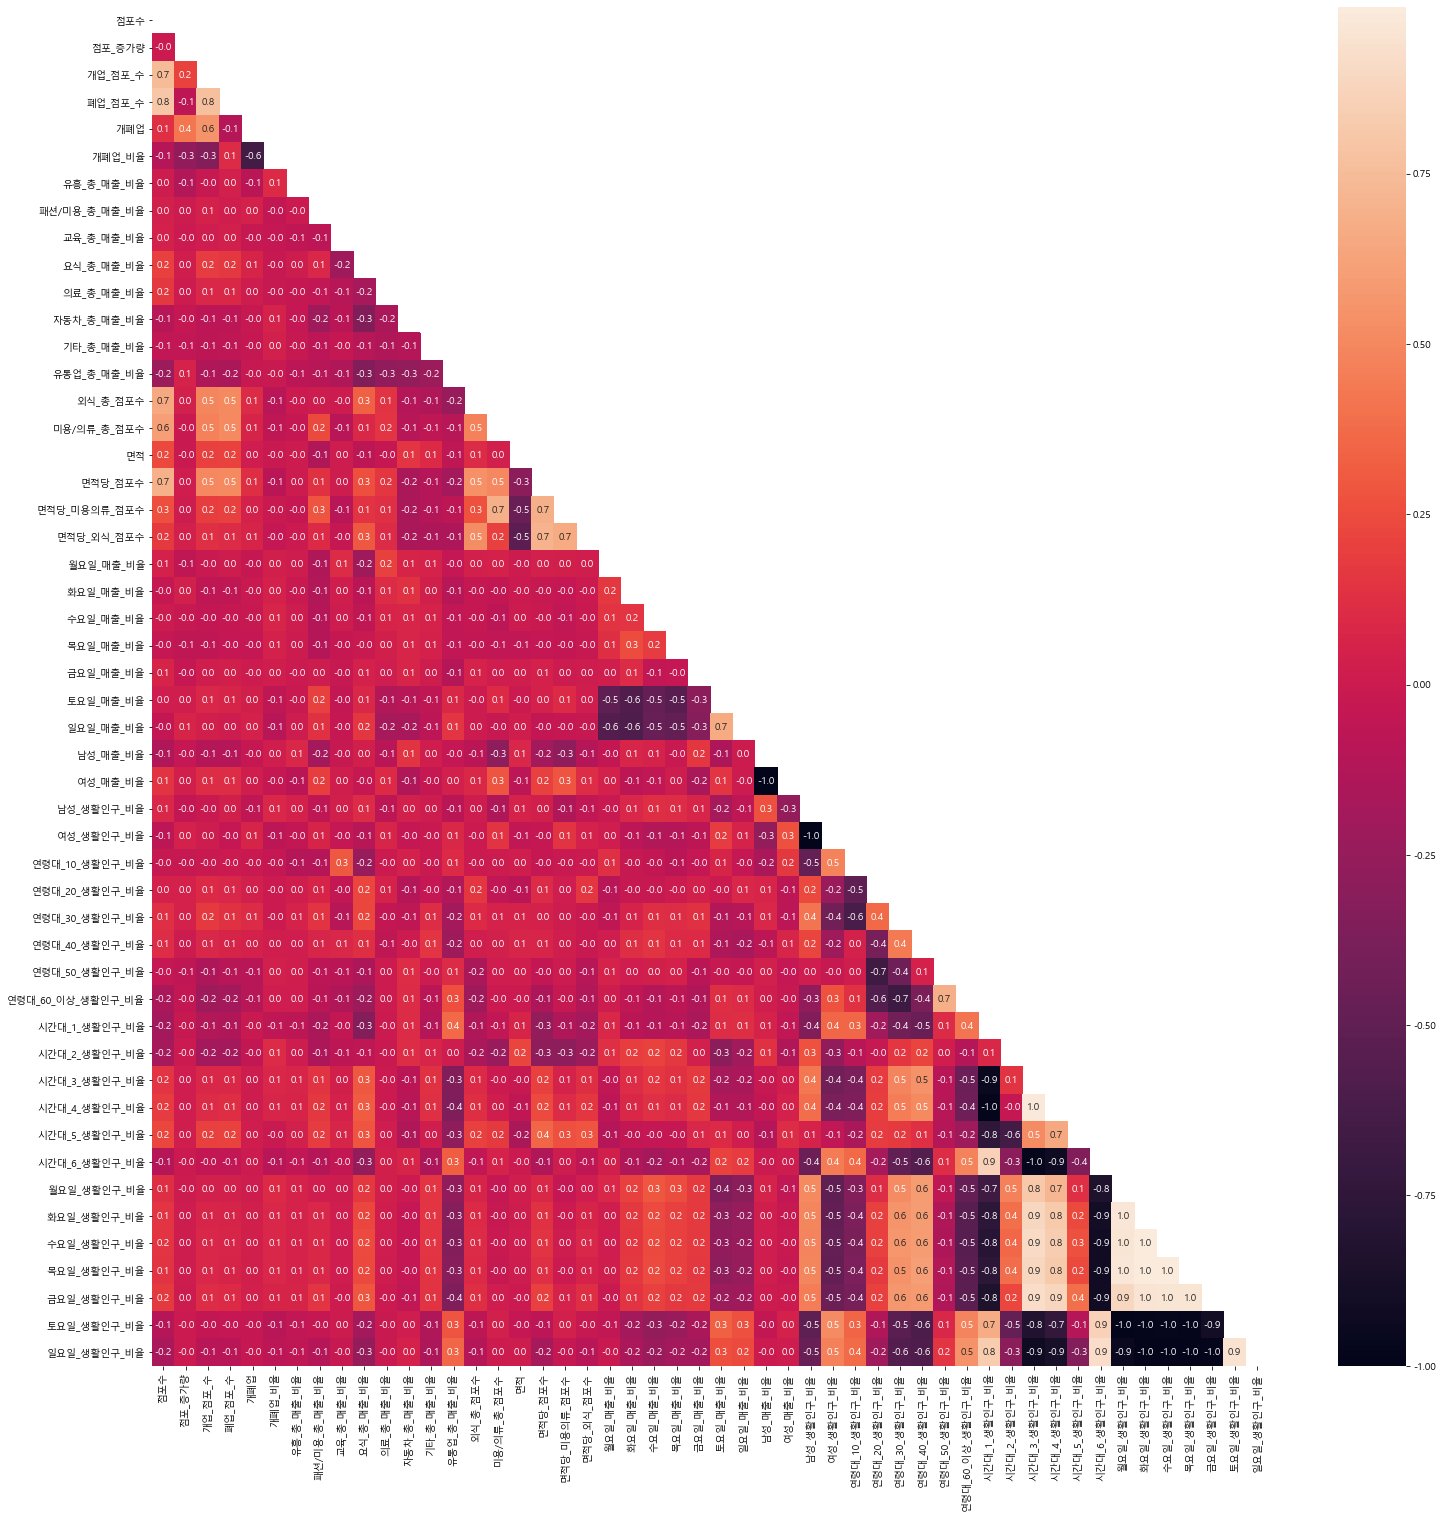

In [18]:
plt.figure(figsize=(25, 25))

mask = np.zeros_like(df_X.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(df_X.corr(), mask=mask, fmt='.1f', annot=True);

In [19]:
model = sm.OLS(df_y, df_X)
regr = model.fit()
data = regr.summary()
data

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     합계   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     52.94
Date:                Thu, 16 Dec 2021   Prob (F-statistic):          2.76e-229
Time:                        15:28:06   Log-Likelihood:                -16128.
No. Observations:                1009   AIC:                         3.235e+04
Df Residuals:                     962   BIC:                         3.258e+04
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
점포수                3.213e+07   2.12e+06     15.175      0.000     2.8e+07    3.63e+07
점포_증가량             2.011e+06   1.52e+06      1.324      0.186   -9.69e+05    4.99e+06
개업_점포_수           -2.076e+10   1.46e+10     -1.426      0.154   -4.93e+10    7.81e+09
폐업_점포_수            1.348e+10   9.45e+09      1.426      0.154   -5.07e+09     3.2e+10
개폐업                 1.93e+10   1.35e+10      1.425      0.154   -7.27e+09    4.59e+10
개폐업_비율            -1.344e+06   8.12e+05     -1.654      0.098   -2.94e+06     2.5e+05
유흥_총_매출_비율         3.017e+10   2.12e+10      1.426      0.154   -1.14e+10    7.17e+10
패션/미용_총_매출_비율      3.349e+10   2.35e+10      1.426      0.154   -1.26e+10    7.96e+10
교육_총_매출_비율         3.419e+10    2.4e+10      1.426      0.154   -1.29e+10    8.13e+10
요식_총_매출_비율         3.448e+10   2.42e+10      1.426      0.154    -1.3e+10    8.19e+10
의료_총_매출_비율         3.548e+10   2.49e+10      1.426      0.154   -1.34e+10    8.43e+10
자동차_총_매출_비율        3.502e+10   2.46e+10      1.426      0.154   -1.32e+10    8.32e+10
기타_총_매출_비율         2.962e+10   2.08e+10      1.426      0.154   -1.12e+10    7.04e+10
유통업_총_매출_비율        3.696e+10   2.59e+10      1.426      0.154   -1.39e+10    8.78e+10
외식_총_점포수           3.853e+05   7.43e+05      0.518      0.604   -1.07e+06    1.84e+06
미용/의류_총_점포수        -3.47e+06   1.07e+06     -3.256      0.001   -5.56e+06   -1.38e+06
면적                 2.652e+06   1.48e+06      1.796      0.073   -2.46e+05    5.55e+06
면적당_점포수           -1.638e+07    3.3e+06     -4.966      0.000   -2.29e+07   -9.91e+06
면적당_미용의류_점포수       8.668e+06   2.59e+06      3.349      0.001    3.59e+06    1.37e+07
면적당_외식_점포수         8.043e+06   2.97e+06      2.708      0.007    2.21e+06    1.39e+07
월요일_매출_비율          9.185e+10   6.44e+10      1.426      0.154   -3.46e+10    2.18e+11
화요일_매출_비율          7.573e+10   5.31e+10      1.426      0.154   -2.85e+10     1.8e+11
수요일_매출_비율          6.739e+10   4.73e+10      1.426      0.154   -2.54e+10     1.6e+11
목요일_매출_비율           5.24e+10   3.68e+10      1.426      0.154   -1.97e+10    1.25e+11
금요일_매출_비율          5.969e+10   4.19e+10      1.426      0.154   -2.25e+10    1.42e+11
토요일_매출_비율          7.172e+10   5.03e+10      1.426      0.154    -2.7e+10     1.7e+11
일요일_매출_비율          7.226e+10   5.07e+10      1.426      0.154   -2.72e+10    1.72e+11
남성_매출_비율           1.127e+11   7.91e+10      1.426      0.154   -4.24e+10    2.68e+11
여성_매출_비율           1.127e+11   7.91e+10      1.426      0.154   -4.24e+10    2.68e+11
남성_생활인구_비율        -7.967e+10   9.29e+10     -0.858      0.391   -2.62e+11    1.03e+11
여성_생활인구_비율        -7.967e+10   9.29e+10     -0.858      0.391   -2.62e+11    1.03e+11
연령대_10_생활인구_비율     1.898e+10   1.16e+11      0.164      0.870   -2.08e+11    2.46e+11
연령대_20_생활인구_비율     2.011e+10   1.23e+11      0.164      0.870   -2.21e+11

# 1차 Feature Selection
## Stepwise(단계적 선택법)

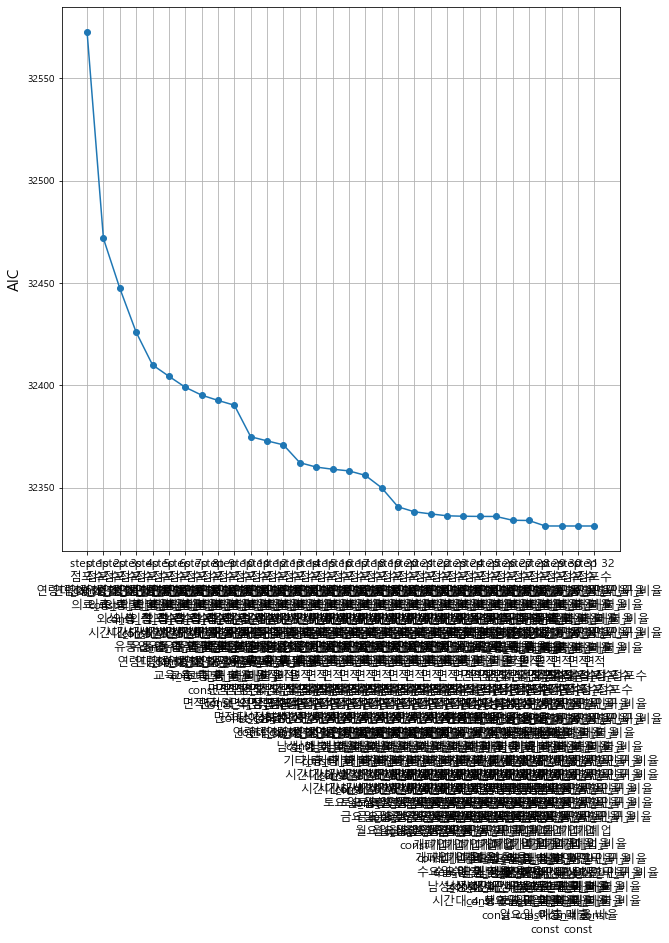

In [20]:
df_X = sm.add_constant(df_X ,has_constant = "add")
s_AIC_model = Stepwise_model(df_X, df_y)
vis_AIC_step(s_AIC_model)

In [21]:
s_best = get_best_summary_by_A(s_AIC_model)
s_best

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     합계   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     100.2
Date:                Thu, 16 Dec 2021   Prob (F-statistic):          1.54e-244
Time:                        15:28:15   Log-Likelihood:                -16141.
No. Observations:                1009   AIC:                         3.233e+04
Df Residuals:                     984   BIC:                         3.245e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
점포수             2.754e+07   1.18e+06     23.378      0.000    2.52e+07    2.98e+07
연령대_20_생활인구_비율  3.147e+06   6.88e+05      4.576      0.000     1.8e+06     4.5e+06
의료_총_매출_비율      2.288e+06   5.37e+05      4.264      0.000    1.23e+06    3.34e+06
유통업_총_매출_비율     6.943e+05   4.46e+05      1.558      0.120    -1.8e+05    1.57e+06
연령대_50_생활인구_비율 -3.361e+06   7.31e+05     -4.597      0.000    -4.8e+06   -1.93e+06
교육_총_매출_비율     -2.344e+06   6.97e+05     -3.362      0.001   -3.71e+06   -9.76e+05
면적              2.222e+06   1.26e+06      1.763      0.078   -2.52e+05     4.7e+06
면적당_외식_점포수      1.071e+07   1.78e+06      6.006      0.000    7.21e+06    1.42e+07
면적당_점포수         -1.02e+07   2.37e+06     -4.300      0.000   -1.49e+07   -5.54e+06
여성_생활인구_비율     -1.321e+11   7.73e+10     -1.709      0.088   -2.84e+11    1.96e+10
연령대_30_생활인구_비율 -1.302e+06   5.83e+05     -2.233      0.026   -2.45e+06   -1.58e+05
남성_매출_비율        4.404e+10   2.58e+10      1.709      0.088   -6.53e+09    9.46e+10
기타_총_매출_비율     -9.963e+05   5.59e+05     -1.782      0.075   -2.09e+06    1.01e+05
시간대_2_생활인구_비율   2.202e+06   1.23e+06      1.787      0.074   -2.16e+05    4.62e+06
시간대_6_생활인구_비율    8.67e+06   3.01e+06      2.879      0.004    2.76e+06    1.46e+07
토요일_생활인구_비율    -1.654e+07   4.59e+06     -3.601      0.000   -2.56e+07   -7.53e+06
금요일_생활인구_비율    -7.103e+06   2.12e+06     -3.357      0.001   -1.13e+07   -2.95e+06
월요일_생활인구_비율    -7.579e+06   3.97e+06     -1.909      0.056   -1.54e+07     2.1e+05
개폐업            -3.021e+06   1.27e+06     -2.380      0.018   -5.51e+06    -5.3e+05
개폐업_비율         -1.192e+06   7.97e+05     -1.495      0.135   -2.76e+06    3.72e+05
남성_생활인구_비율     -1.321e+11   7.73e+10     -1.709      0.088   -2.84e+11    1.96e+10
시간대_4_생활인구_비율   6.821e+06   2.73e+06      2.497      0.013    1.46e+06    1.22e+07
토요일_매출_비율      -1.917e+06   8.98e+05     -2.134      0.033   -3.68e+06   -1.55e+05
일요일_매출_비율        2.01e+06   8.12e+05      2.475      0.013    4.16e+05     3.6e+06
여성_매출_비율        4.404e+10   2.58e+10      1.709      0.088   -6.53e+09    9.46e+10
const           8.808e+10   5.15e+10      1.709      0.088   -1.31e+10    1.89e+11
==============================================================================
Omnibus:                      174.127   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              860.366
Skew:                           0.701   Prob(JB):                    1.49e-187
Kurtosis:                       7.301   Cond. No.                     1.20e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.39e-29. This might indicate that there are
strong multicollinearity p

# 2차 Feature Selection
## PCA

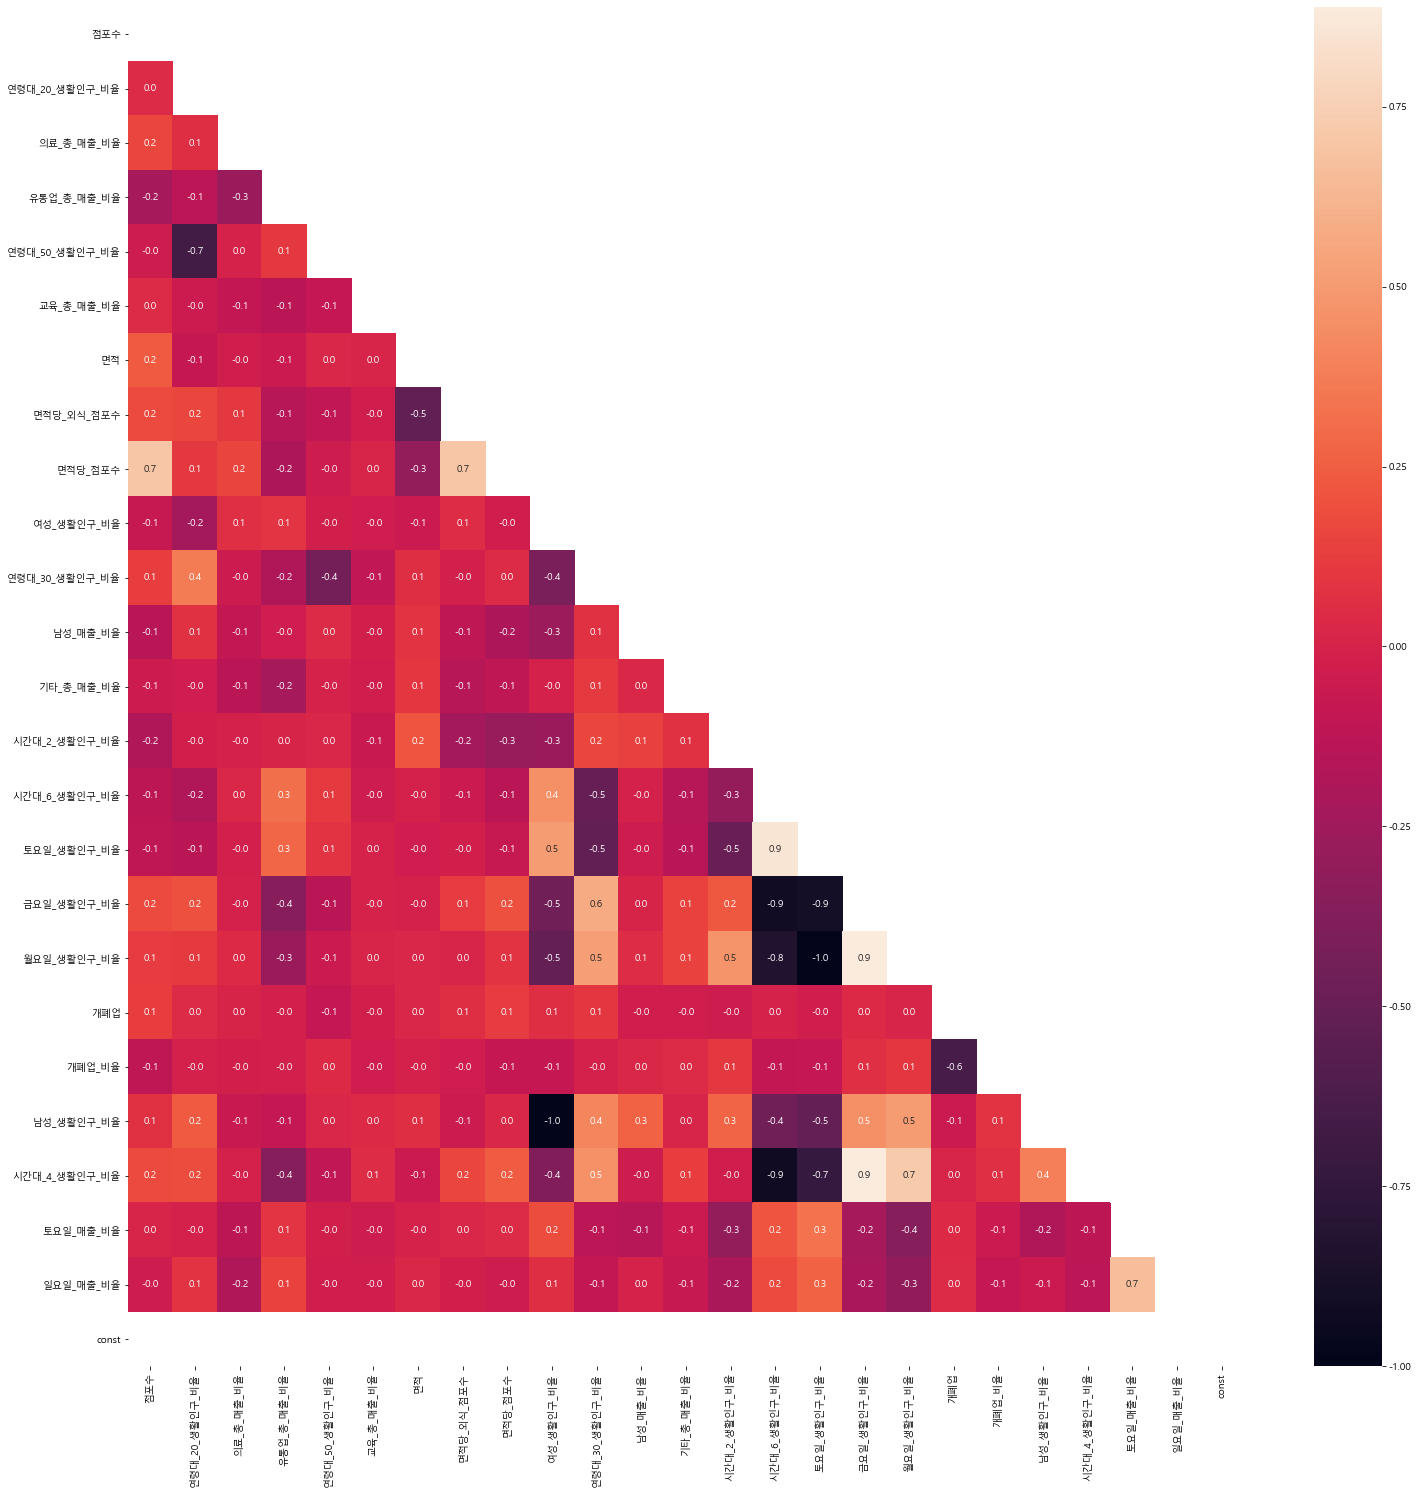

In [22]:
col = s_AIC_model.iloc[-1,-1]
best_df = df_X[col]

plt.figure(figsize=(25, 25))

mask = np.zeros_like(best_df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(best_df.corr(), mask=mask, fmt='.1f', annot=True);

In [23]:
pca_df = best_df.copy()

pca_cols = [  ['점포수', '면적당_점포수'],  # 점포수 관련 Feature
              ['여성_생활인구_비율', '남성_생활인구_비율'],  # 성별 생활인구 관련 Feature
              ['토요일_매출_비율', '일요일_매출_비율'],  # 주말 매출 관련 Feature
              ['금요일_생활인구_비율', '토요일_생활인구_비율', '월요일_생활인구_비율', 
                                    '시간대_4_생활인구_비율', '시간대_6_생활인구_비율']  ] # 생활인구 관련 Feature 들을 
                                                                                                        # 각각 1차원으로 축소

new_cols = ['점포_pca',
            '성별_pca',
            '주말_매출_pca',
            '생활인구_비율_pca']  # 새로운 컬럼 이름

for pca_col, new_col in zip(pca_cols, new_cols):
    pca_df = decompo_pca(pca_df, pca_col, new_col)
    
# 컬럼 순서 조정
pca_df = pca_df[['연령대_20_생활인구_비율', '의료_총_매출_비율', '유통업_총_매출_비율',
                 '연령대_50_생활인구_비율', '교육_총_매출_비율', '면적',
                 '면적당_외식_점포수', '연령대_30_생활인구_비율', '남성_매출_비율',
                 '기타_총_매출_비율', '시간대_2_생활인구_비율','개폐업',
                 '개폐업_비율', '점포_pca',
                 '성별_pca', '주말_매출_pca', '생활인구_비율_pca', 'const']]
pca_df.head()

,연령대_20_생활인구_비율,의료_총_매출_비율,유통업_총_매출_비율,연령대_50_생활인구_비율,교육_총_매출_비율,면적,면적당_외식_점포수,연령대_30_생활인구_비율,남성_매출_비율,기타_총_매출_비율,시간대_2_생활인구_비율,개폐업,개폐업_비율,점포_pca,성별_pca,주말_매출_pca,생활인구_비율_pca,const
상권_코드,,,,,,,,,,,,,,,,,,
1000001,0.1770,0.0212,0.1395,0.5389,0.0369,0.3040,0.0777,0.5126,0.2122,0.2551,0.8052,0.3585,0.0000,-0.0109,0.2511,0.1718,0.6699,1.0000
1000002,0.2387,0.0000,0.2561,0.6304,0.0000,0.0559,0.1317,0.5059,0.2357,0.1567,0.5612,0.1698,0.2857,-0.0747,0.2052,0.2788,0.2403,1.0000
1000003,0.2986,0.0004,0.0897,0.6128,0.6464,0.2734,0.0978,0.4892,0.5256,0.0621,0.2855,0.0943,0.2857,0.1550,0.7509,0.1333,0.8646,1.0000
1000004,0.6113,0.0737,0.4190,0.1990,0.0281,0.0886,0.2291,0.1065,0.4777,0.1249,0.7004,0.2642,0.0000,-0.0478,-0.0480,-0.0446,-0.0972,1.0000
1000005,0.1046,0.0000,0.0674,0.6576,0.0131,0.9444,0.0189,0.1490,0.3670,0.1015,0.7068,0.2264,0.1429,-0.1670,-0.0335,0.3830,-0.1163,1.0000


In [24]:
model = sm.OLS(df_y, pca_df)
regr = model.fit()
data = regr.summary()
data

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     합계   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     118.6
Date:                Thu, 16 Dec 2021   Prob (F-statistic):          9.12e-225
Time:                        15:28:22   Log-Likelihood:                -16205.
No. Observations:                1009   AIC:                         3.245e+04
Df Residuals:                     991   BIC:                         3.253e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
연령대_20_생활인구_비율  3.087e+06   7.18e+05      4.300      0.000    1.68e+06     4.5e+06
의료_총_매출_비율      2.622e+06   5.62e+05      4.665      0.000    1.52e+06    3.72e+06
유통업_총_매출_비율      5.92e+05   4.62e+05      1.280      0.201   -3.16e+05     1.5e+06
연령대_50_생활인구_비율 -3.533e+06   7.71e+05     -4.583      0.000   -5.05e+06   -2.02e+06
교육_총_매출_비율     -2.314e+06    7.3e+05     -3.169      0.002   -3.75e+06   -8.81e+05
면적              6.918e+06   1.18e+06      5.882      0.000    4.61e+06    9.23e+06
면적당_외식_점포수      6.747e+05   1.38e+06      0.490      0.625   -2.03e+06    3.38e+06
연령대_30_생활인구_비율 -1.193e+06      6e+05     -1.989      0.047   -2.37e+06   -1.57e+04
남성_매출_비율       -6.824e+05   5.71e+05     -1.195      0.233    -1.8e+06    4.39e+05
기타_총_매출_비율     -1.257e+06   5.91e+05     -2.129      0.033   -2.42e+06   -9.84e+04
시간대_2_생활인구_비율   2.364e+06   7.08e+05      3.337      0.001    9.74e+05    3.75e+06
개폐업            -2.854e+06   1.34e+06     -2.134      0.033   -5.48e+06    -2.3e+05
개폐업_비율         -1.353e+06   8.43e+05     -1.606      0.109   -3.01e+06       3e+05
점포_pca          2.083e+07   6.24e+05     33.372      0.000    1.96e+07    2.21e+07
성별_pca          1.248e+06   5.34e+05      2.335      0.020    1.99e+05     2.3e+06
주말_매출_pca       1.198e+05   5.31e+05      0.226      0.821   -9.21e+05    1.16e+06
생활인구_비율_pca    -6.415e+05   4.06e+05     -1.578      0.115   -1.44e+06    1.56e+05
const           5.349e+06   9.58e+05      5.583      0.000    3.47e+06    7.23e+06
==============================================================================
Omnibus:                      190.833   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3575.915
Skew:                           0.267   Prob(JB):                         0.00
Kurtosis:                      12.207   Cond. No.                         34.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

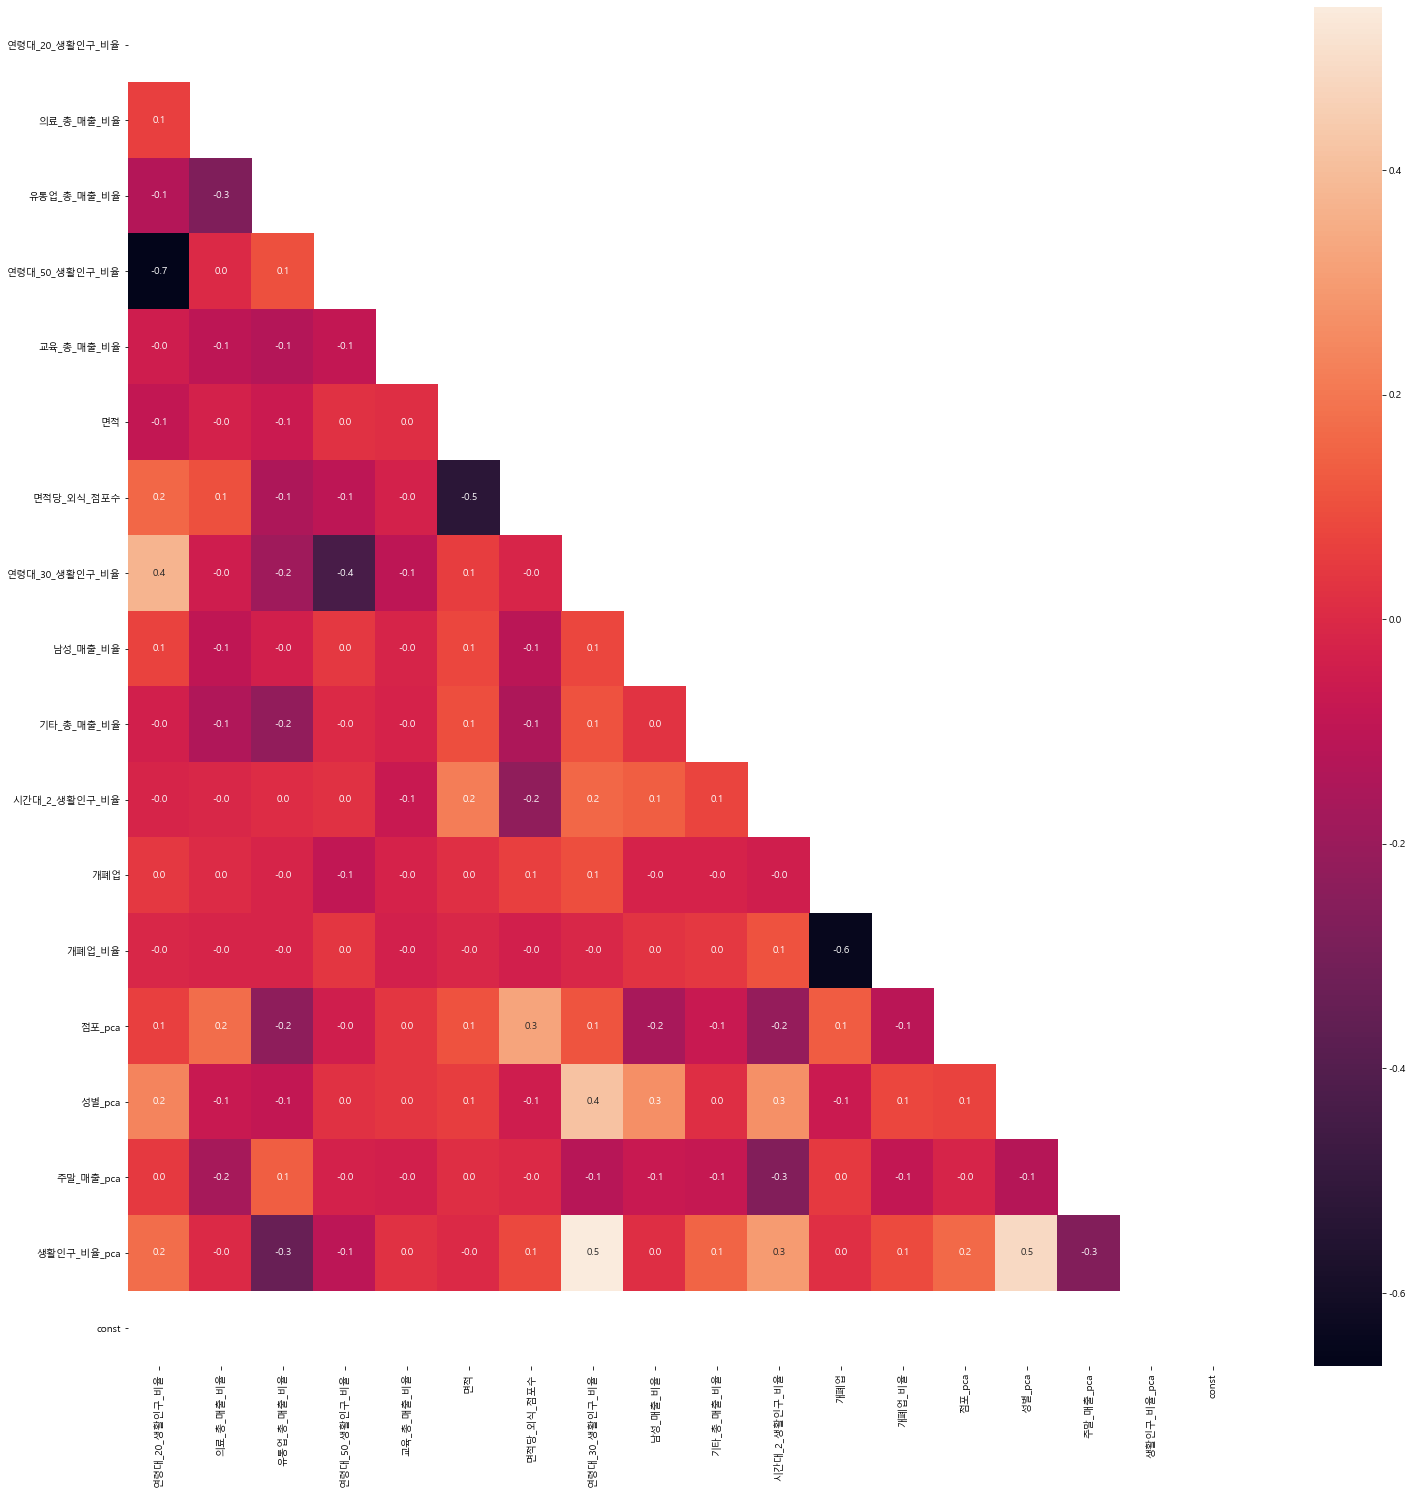

In [25]:
plt.figure(figsize=(25, 25))

mask = np.zeros_like(pca_df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(pca_df.corr(), mask=mask, fmt='.1f', annot=True);

# 최종 폴더 저장

In [26]:
pca_df.to_csv('./data/indicator/fs_dec.csv')
pd.read_csv('./data/indicator/fs_dec.csv').head()

,상권_코드,연령대_20_생활인구_비율,의료_총_매출_비율,유통업_총_매출_비율,연령대_50_생활인구_비율,교육_총_매출_비율,면적,면적당_외식_점포수,연령대_30_생활인구_비율,남성_매출_비율,기타_총_매출_비율,시간대_2_생활인구_비율,개폐업,개폐업_비율,점포_pca,성별_pca,주말_매출_pca,생활인구_비율_pca,const
0,1000001,0.1770,0.0212,0.1395,0.5389,0.0369,0.3040,0.0777,0.5126,0.2122,0.2551,0.8052,0.3585,0.0000,-0.0109,0.2511,0.1718,0.6699,1.0000
1,1000002,0.2387,0.0000,0.2561,0.6304,0.0000,0.0559,0.1317,0.5059,0.2357,0.1567,0.5612,0.1698,0.2857,-0.0747,0.2052,0.2788,0.2403,1.0000
2,1000003,0.2986,0.0004,0.0897,0.6128,0.6464,0.2734,0.0978,0.4892,0.5256,0.0621,0.2855,0.0943,0.2857,0.1550,0.7509,0.1333,0.8646,1.0000
3,1000004,0.6113,0.0737,0.4190,0.1990,0.0281,0.0886,0.2291,0.1065,0.4777,0.1249,0.7004,0.2642,0.0000,-0.0478,-0.0480,-0.0446,-0.0972,1.0000
4,1000005,0.1046,0.0000,0.0674,0.6576,0.0131,0.9444,0.0189,0.1490,0.3670,0.1015,0.7068,0.2264,0.1429,-0.1670,-0.0335,0.3830,-0.1163,1.0000
